In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime  
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import seaborn as sns

import xgboost as xgb

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import math

C:\Users\usuario\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
os.chdir("C:\\Users\\usuario\\Documents\\Data_science\\data\\")
os.getcwd()

'C:\\Users\\usuario\\Documents\\Data_science\\data'

In [4]:
data_2015_1Q=pd.read_excel("Q/2015_1H.xlsx")
data_2015_2Q=pd.read_excel("Q/2015_2H.xlsx")
data_2016_1Q=pd.read_excel("Q/2016_1Q.xls")
data_2016_2Q=pd.read_excel("Q/2016_2Q.xls")
data_2016_3Q=pd.read_excel("Q/2016_3Q.xls")
data_2016_4Q=pd.read_excel("Q/2016_4Q.xls")
data_2017_1Q=pd.read_excel("Q/2017_1Q.xls")
data_2017_2Q=pd.read_excel("Q/2017_2Q.xls")
data_2017_3Q=pd.read_excel("Q/2017_3Q.xls")
data_2017_4Q=pd.read_excel("Q/2017_4Q.xls")
data_2018_1Q=pd.read_excel("Q/2018_1Q.xls")
data_2018_2Q=pd.read_excel("Q/2018_2Q.xls")
data_2018_3Q=pd.read_excel("Q/2018_3Q.xls")
data_2018_4Q=pd.read_excel("Q/2018_4Q.xls")

In [5]:
historical_data = pd.concat([data_2015_1Q, data_2015_2Q
                    , data_2016_1Q, data_2016_2Q, data_2016_3Q, data_2016_4Q
                    , data_2017_1Q, data_2017_2Q, data_2017_3Q, data_2017_4Q
                    , data_2018_1Q, data_2018_2Q, data_2018_3Q, data_2018_4Q
                   ])

In [6]:
meses=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]
codigo=range(1, 13)
cod_mes=pd.DataFrame({"mes":meses, "cod_mes":codigo})

In [7]:
historical_data=historical_data.merge(cod_mes, left_on="MesEstadia", right_on="mes", how="left")

In [8]:
historical_data["fecha"]=pd.to_datetime(historical_data.AñoEstadia.map(str)+"-"+historical_data.cod_mes.map(str)+"-"+historical_data.DiaEstadia.map(str))

In [23]:
historical_data["ADR_fixed"]=np.divide(historical_data.RoomRev, historical_data.Noches)

C:\Users\usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [25]:
hotel="CAP MIRAFLORES"
fecha_actual="2018-11-12"
df=historical_data[(historical_data.Hotel==hotel) &(historical_data.fecha<=fecha_actual)]

In [26]:
resumen={"OCUP":sum, "DiaSemanaEstadia":"first", "fecha":"first", "ADR_fixed":"mean"}
df_1=df.groupby(by=["AñoEstadia", "MesEstadia", "DiaEstadia"], as_index=False).agg(resumen)

In [27]:
df_1.MesEstadia=df_1.MesEstadia.astype("category")
df_1.DiaSemanaEstadia=df_1.DiaSemanaEstadia.astype("category")

In [28]:
df_1=pd.get_dummies(df_1, columns=["MesEstadia", "DiaSemanaEstadia"])

In [29]:
df_1.columns

Index(['AñoEstadia', 'DiaEstadia', 'OCUP', 'fecha', 'ADR_fixed',
       'MesEstadia_Abr', 'MesEstadia_Ago', 'MesEstadia_Dic', 'MesEstadia_Ene',
       'MesEstadia_Feb', 'MesEstadia_Jul', 'MesEstadia_Jun', 'MesEstadia_Mar',
       'MesEstadia_May', 'MesEstadia_Nov', 'MesEstadia_Oct', 'MesEstadia_Sep',
       'DiaSemanaEstadia_Dom', 'DiaSemanaEstadia_Jue', 'DiaSemanaEstadia_Lun',
       'DiaSemanaEstadia_Mar', 'DiaSemanaEstadia_Mié', 'DiaSemanaEstadia_Sáb',
       'DiaSemanaEstadia_Vie'],
      dtype='object')

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def medidas_de_error(y, y_pred):
    print("MAE", mean_absolute_error(y, y_pred), 
          "\n""MAPE", mean_absolute_percentage_error(y, y_pred), 
          "\n""RMSE", np.sqrt(mean_squared_error(y, y_pred)))

In [74]:
df_train, df_test=train_test_split(df_1, test_size=0.1)

In [75]:
variables_indep=['AñoEstadia', 'DiaEstadia', 'MesEstadia_Abr',
       'MesEstadia_Ago', 'MesEstadia_Dic', 'MesEstadia_Ene', 'MesEstadia_Feb',
       'MesEstadia_Jul', 'MesEstadia_Jun', 'MesEstadia_Mar', 'MesEstadia_May',
       'MesEstadia_Nov', 'MesEstadia_Oct', 'MesEstadia_Sep',
       'DiaSemanaEstadia_Dom', 'DiaSemanaEstadia_Jue', 'DiaSemanaEstadia_Lun',
       'DiaSemanaEstadia_Mar', 'DiaSemanaEstadia_Mié', 'DiaSemanaEstadia_Sáb',
       'DiaSemanaEstadia_Vie']

In [76]:
# variables_indep=['DiaEstadia', 'MesEstadia_Abr',
#        'MesEstadia_Ago', 'MesEstadia_Dic', 'MesEstadia_Ene', 'MesEstadia_Feb',
#        'MesEstadia_Jul', 'MesEstadia_Jun', 'MesEstadia_Mar', 'MesEstadia_May',
#        'MesEstadia_Nov', 'MesEstadia_Oct', 'MesEstadia_Sep',
#        'DiaSemanaEstadia_Dom', 'DiaSemanaEstadia_Jue', 'DiaSemanaEstadia_Lun',
#        'DiaSemanaEstadia_Mar', 'DiaSemanaEstadia_Mié', 'DiaSemanaEstadia_Sáb',
#        'DiaSemanaEstadia_Vie']

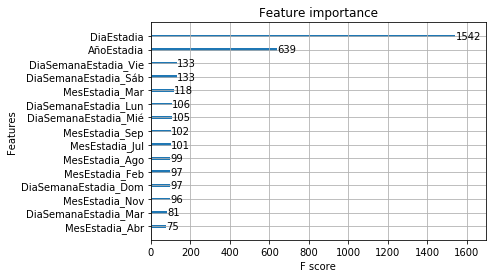

In [77]:
y_train=df_train["OCUP"]
X_train=df_train[variables_indep]
y_test=df_test["OCUP"]
X_test=df_test[variables_indep]
xgb_model=xgb.XGBRegressor(n_jobs=-1,n_estimators=100,subsample=0.75, max_depth=8, eta=0.01, alpha=0.01, gamma=0.01, silent=True)
xgb_model.fit(X_train, y_train)
xgb.plot_importance(xgb_model, max_num_features=15)

In [78]:
y_p_train=xgb_model.predict(X_train)
y_p_test=xgb_model.predict(X_test)
medidas_de_error(y_train, y_p_train)
medidas_de_error(y_test, y_p_test)

MAE 0.04225960821220232 
MAPE 0.05623430894092933 
RMSE 0.05230231515589172
MAE 0.09284713969182556 
MAPE 0.1221191798273347 
RMSE 0.11520275172616076


In [22]:
feriados=pd.DataFrame(columns=["fecha", "DiaSemana", "feriado"])

In [23]:
feriados=feriados.append({"fecha":pd.to_datetime("2015-01-01"), "DiaSemana":"Jue", "feriado":"Anho nuevo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-04-02"), "DiaSemana":"Jue", "feriado":"Jueves Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-04-03"), "DiaSemana":"Vie", "feriado":"Viernes Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-05-01"), "DiaSemana":"Vie", "feriado":"Día del trabajo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-06-29"), "DiaSemana":"Lun", "feriado":"San Pedro y San Pablo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-07-28"), "DiaSemana":"Mar", "feriado":"Día de la Independencia"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-07-29"), "DiaSemana":"Mie", "feriado":"Día de las Fuerzas Armadas y la Policía del Perú"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-08-30"), "DiaSemana":"Dom", "feriado":"Día de Santa Rosa de Lima"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-10-08"), "DiaSemana":"Jue", "feriado":"Combate Naval de Angamos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-11-01"), "DiaSemana":"Dom", "feriado":"Día de Todos Los Santos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-12-08"), "DiaSemana":"Mar", "feriado":"Inmaculada Concepción"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2015-12-25"), "DiaSemana":"Vie", "feriado":"Navidad"}, ignore_index=True)

In [24]:
feriados=feriados.append({"fecha":pd.to_datetime("2016-01-01"), "DiaSemana":"Vie", "feriado":"Anho nuevo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-03-24"), "DiaSemana":"Jue", "feriado":"Jueves Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-03-25"), "DiaSemana":"Vie", "feriado":"Viernes Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-05-01"), "DiaSemana":"Dom", "feriado":"Día del trabajo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-06-29"), "DiaSemana":"Mie", "feriado":"San Pedro y San Pablo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-07-28"), "DiaSemana":"Jue", "feriado":"Día de la Independencia"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-07-29"), "DiaSemana":"Vie", "feriado":"Día de las Fuerzas Armadas y la Policía del Perú"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-08-30"), "DiaSemana":"Mar", "feriado":"Día de Santa Rosa de Lima"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-10-08"), "DiaSemana":"Sab", "feriado":"Combate Naval de Angamos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-11-01"), "DiaSemana":"Mar", "feriado":"Día de Todos Los Santos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-11-17"), "DiaSemana":"Jue", "feriado":"APEC"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-11-18"), "DiaSemana":"Vie", "feriado":"APEC"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-11-19"), "DiaSemana":"Sab", "feriado":"APEC"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-12-08"), "DiaSemana":"Jue", "feriado":"Inmaculada Concepción"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2016-12-25"), "DiaSemana":"Dom", "feriado":"Navidad"}, ignore_index=True)

In [25]:
feriados=feriados.append({"fecha":pd.to_datetime("2017-01-01"), "DiaSemana":"Dom", "feriado":"Anho nuevo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-04-13"), "DiaSemana":"Jue", "feriado":"Jueves Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-04-14"), "DiaSemana":"Vie", "feriado":"Viernes Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-05-01"), "DiaSemana":"Lun", "feriado":"Día del trabajo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-06-29"), "DiaSemana":"Jue", "feriado":"San Pedro y San Pablo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-07-28"), "DiaSemana":"Vie", "feriado":"Día de la Independencia"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-07-29"), "DiaSemana":"Sab", "feriado":"Día de las Fuerzas Armadas y la Policía del Perú"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-08-30"), "DiaSemana":"Mie", "feriado":"Día de Santa Rosa de Lima"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-10-08"), "DiaSemana":"Dom", "feriado":"Combate Naval de Angamos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-11-01"), "DiaSemana":"Mie", "feriado":"Día de Todos Los Santos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-12-08"), "DiaSemana":"Vie", "feriado":"Inmaculada Concepción"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2017-12-25"), "DiaSemana":"Lun", "feriado":"Navidad"}, ignore_index=True)

In [26]:
feriados=feriados.append({"fecha":pd.to_datetime("2018-01-01"), "DiaSemana":"Lun", "feriado":"Anho nuevo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-03-29"), "DiaSemana":"Jue", "feriado":"Jueves Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-03-30"), "DiaSemana":"Vie", "feriado":"Viernes Santo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-05-01"), "DiaSemana":"Mar", "feriado":"Día del trabajo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-06-29"), "DiaSemana":"Vie", "feriado":"San Pedro y San Pablo"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-07-28"), "DiaSemana":"Sab", "feriado":"Día de la Independencia"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-07-29"), "DiaSemana":"Dom", "feriado":"Día de las Fuerzas Armadas y la Policía del Perú"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-08-30"), "DiaSemana":"Jue", "feriado":"Día de Santa Rosa de Lima"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-10-08"), "DiaSemana":"Lun", "feriado":"Combate Naval de Angamos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-11-01"), "DiaSemana":"Jue", "feriado":"Día de Todos Los Santos"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-12-08"), "DiaSemana":"Sab", "feriado":"Inmaculada Concepción"}, ignore_index=True)
feriados=feriados.append({"fecha":pd.to_datetime("2018-12-25"), "DiaSemana":"Mar", "feriado":"Navidad"}, ignore_index=True)

In [27]:
feriados["flag_feriado"]=1

In [28]:
df_2=df_1.merge(feriados[["fecha", "flag_feriado"]], on=["fecha"], how="left").fillna(0)

In [29]:
df_2.head()

,AñoEstadia,DiaEstadia,OCUP,fecha,MesEstadia_Abr,MesEstadia_Ago,MesEstadia_Dic,MesEstadia_Ene,MesEstadia_Feb,MesEstadia_Jul,...,MesEstadia_Oct,MesEstadia_Sep,DiaSemanaEstadia_Dom,DiaSemanaEstadia_Jue,DiaSemanaEstadia_Lun,DiaSemanaEstadia_Mar,DiaSemanaEstadia_Mié,DiaSemanaEstadia_Sáb,DiaSemanaEstadia_Vie,flag_feriado
0,2015,1,0.6426,2015-04-01,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
1,2015,2,0.7505,2015-04-02,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.0
2,2015,3,0.7980,2015-04-03,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
3,2015,4,0.8113,2015-04-04,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
4,2015,5,0.6226,2015-04-05,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.0


In [30]:
df_train, df_test=train_test_split(df_2, test_size=0.3)

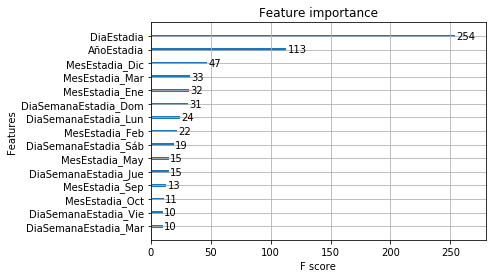

In [33]:
variables_indep=[ 'AñoEstadia', 'DiaEstadia','MesEstadia_Abr',
       'MesEstadia_Ago', 'MesEstadia_Dic', 'MesEstadia_Ene', 'MesEstadia_Feb',
       'MesEstadia_Jul', 'MesEstadia_Jun', 'MesEstadia_Mar', 'MesEstadia_May',
       'MesEstadia_Nov', 'MesEstadia_Oct', 'MesEstadia_Sep',
       'DiaSemanaEstadia_Dom', 'DiaSemanaEstadia_Jue', 'DiaSemanaEstadia_Lun',
       'DiaSemanaEstadia_Mar', 'DiaSemanaEstadia_Mié', 'DiaSemanaEstadia_Sáb',
       'DiaSemanaEstadia_Vie', "flag_feriado"]
y_train=df_train["OCUP"]
X_train=df_train[variables_indep]
y_test=df_test["OCUP"]
X_test=df_test[variables_indep]
xgb_model=xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb.plot_importance(xgb_model, max_num_features=15)

In [34]:
y_p_train=xgb_model.predict(X_train)
y_p_test=xgb_model.predict(X_test)
medidas_de_error(y_train, y_p_train)
medidas_de_error(y_test, y_p_test)

MAE 0.07965742045949963 
MAPE 0.11120386387282867 
RMSE 0.10061448512384863
MAE 0.08215407899412379 
MAPE 0.11257522404603304 
RMSE 0.10350018642877142
